In [1]:
# Load images into image vector matrix - where each row is an image vector
import os

import glob
import cv2
import numpy as np

# Path templates
category_directories_template =  "food_resized/*/[0-9]*_*"
image_files_template = "food_resized/*/*/*.jpg"

#  return cid, name for a given category directory path i.e. 
# 'food_resized/train/0_hot_dog' ---> 0, "hot_dog"
#       use: cid, name = cid_name_from_path(path_string)
def cname_cid_from_path(path_string):
    
    base_dir = None
    if os.path.isfile(path_string):
        base_dir = os.path.basename(os.path.split(path_string)[0])
    elif os.path.isdir(path_string):
        base_dir = os.path.basename(path_string)
    else: 
        raise("Error incorect path")
    
    cid = int(base_dir.split('_')[0]) # get leading number, or cid
    
    idx = base_dir.find('_') + 1      # get trailing string after first '_'
    cname = base_dir[idx:]

    return cname, cid

# {'chicken_wings': 0, 'dumplings': 1, 'hot_dog': 2, 'ramen': 3, 'sushi': 4}
def get_category_cname_cid_map(category_directories_template):
    category_folders = glob.glob(category_directories_template)
    return dict(map(cname_cid_from_path, category_folders))

def image_to_vector(image):
    return image.reshape((1, -1)) / 255

# image_vector of original size 60, 60, 3 back to np image
def image_vector_to_image(image_vector, original_image_size=(60,60,3)):
    image_vector = image_vector * 255
    image_vector = image_vector.astype(int)
    image_vector = image_vector.reshape(original_image_size)
    return image_vector

def get_sample_images_and_labels(images_file_template, gray=False):
    
    image_paths = glob.glob(image_files_template)
    
    images = []
    labels = []
    
    for fname in image_paths:
        
        label, cid = cname_cid_from_path(fname)
        
        img = None
        if gray == True:
            img = cv2.imread(fname,0)
        else:
            img = cv2.imread(fname)
        
            # color stored in incorrect order for plt -> convert to RGB order
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        images.append(img)
        labels.append(label)
        
    return images, labels

#load all images into matrix of image vectors, X, and corrresponding vector of categories, y
def get_sample_image_vector_matrix_and_targets(images, labels, cname_cid_dict):
    
    X = image_to_vector(images[0])
    y = []

    for img, l in zip(images, labels):
        
        v = image_to_vector(img) # convert image to vector
        X = np.vstack([X,v])     # add image vector to matrix
        
        y.append(cname_cid_dict[l])
        
    y = np.array(y)
    
    return X,y

#
# load all images into matrix of image vectors, X, and corrresponding vector of categories, y
#

cname_cid_dict = get_category_cname_cid_map(category_directories_template) # get cname:cid dictonary
images, labels = get_sample_images_and_labels(image_files_template, gray=False)

% time X,y = get_sample_image_vector_matrix_and_targets(images, labels, cname_cid_dict)  

# save original shape of images
original_image_shape = images[0].shape

CPU times: user 42.3 s, sys: 48.6 s, total: 1min 30s
Wall time: 1min 43s


In [2]:
# above operation takes a long time save results to files
import pickle
pickle.dump(X, open( 'large_data/X.p', 'wb' ))
pickle.dump(y, open( 'large_data/y.p', 'wb' ))

In [3]:
# load
import pickle
X = pickle.load(open( 'large_data/X.p', 'rb' ))
y = pickle.load(open( 'large_data/y.p', 'rb' ))

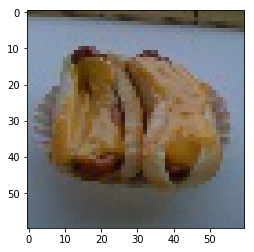

In [6]:
import matplotlib.pyplot as plt

idx = 0
v = X[idx]

image = image_vector_to_image(v, original_image_size=original_image_shape) #reconstruct image from vector
plt.imshow(image)

In [7]:
help(cv2.xfeatures2d.SIFT_create())
help(cv2.xfeatures2d)

Help on xfeatures2d_SIFT object:

class xfeatures2d_SIFT(Feature2D)
 |  Method resolution order:
 |      xfeatures2d_SIFT
 |      Feature2D
 |      Algorithm
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  create(...) from builtins.type
 |      create([, nfeatures[, nOctaveLayers[, contrastThreshold[, edgeThreshold[, sigma]]]]]) -> retval
 |      .   @param nfeatures The number of best features to retain. The features are ranked by their scores
 |      .   (measured in SIFT algorithm as the local contrast)
 |      .   
 |      .   @param nOctaveLayers The number of layers in each octave. 3 is the value used in D. Lowe paper. The
 |      .   number of octaves is computed automatically from the image resolution.
 |      .   
 |      .   @param contrastThreshold The contrast threshold used

In [12]:
import math
import time

def modified_sigmoid(x, k):
     return 1 / (1 + math.exp(-x/k)) - 0.5

def to_gray(image):
    # converting image to grayscale
    # must save the image again to use cv2.convert color, path must be relative
    local_path = 'tmp.jpg'
    cv2.imwrite(local_path, image)
    img = cv2.imread(local_path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray


def sift_distance(gray1, gray2, original=None):

    img1 = gray1
    img2 = gray2

    # ORB Detector
    #orb = cv2.ORB_create()
    #kp1, des1 = orb.detectAndCompute(img1, None)
    #kp2, des2 = orb.detectAndCompute(img2, None)

    # Brute Force Matching
    #bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    #matches = bf.match(des1, des2)
    #matches = sorted(matches, key = lambda x:x.distance)
    
    # find the keypoints and descriptors with SIFT
    Sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = Sift.detectAndCompute(img1,None)
    kp2, des2 = Sift.detectAndCompute(img2,None)
    
    # Brute Force Matching
    bf = cv2.BFMatcher()
    
    matches = bf.knnMatch(des1,des2, k=2)

    #Apply ratio test
    threshold = 0.88
    good_matches = 0
    for m,n in matches:
        if m.distance < threshold * n.distance:
            good_matches += 1

    return modified_sigmoid(good_matches, 5)


# number of images
n = X.shape[0]

# distance matrix
D = np.zeros(shape=(n,n))


start = time.time()
for i in range(n):
    p = i/n
    print("%s percent complete" % p)
    for j in range(i, int(n/2)):
        
        idx1= i
        idx2 = j

        im1 = image_vector_to_image(X[idx1])
        im2 = image_vector_to_image(X[idx2])
        gray1 = to_gray(im1)
        gray2 = to_gray(im2)

        sd = sift_distance(gray1, gray2)
        
        D[i,j] = sd
        D[j,i] = sd

        
# set diagnols to zero
np.fill_diagonal(D, 0)
end = time.time()
print("time: %s" % (end - start))

print(D)

# above operation takes a long time save results to files
import pickle
pickle.dump(X, open( 'large_data/D.p', 'wb' ))

0.0 percent complete
0.0005711022272986865 percent complete
0.001142204454597373 percent complete
0.0017133066818960593 percent complete
0.002284408909194746 percent complete
0.0028555111364934323 percent complete
0.0034266133637921186 percent complete
0.003997715591090805 percent complete
0.004568817818389492 percent complete
0.005139920045688178 percent complete
0.0057110222729868645 percent complete
0.006282124500285551 percent complete
0.006853226727584237 percent complete
0.0074243289548829245 percent complete
0.00799543118218161 percent complete
0.008566533409480296 percent complete
0.009137635636778984 percent complete
0.009708737864077669 percent complete
0.010279840091376356 percent complete
0.010850942318675044 percent complete
0.011422044545973729 percent complete
0.011993146773272416 percent complete
0.012564249000571102 percent complete
0.013135351227869789 percent complete
0.013706453455168474 percent complete
0.014277555682467162 percent complete
0.014848657909765849 per

0.1262135922330097 percent complete
0.1267846944603084 percent complete
0.12735579668760708 percent complete
0.12792689891490577 percent complete
0.12849800114220444 percent complete
0.12906910336950314 percent complete
0.12964020559680184 percent complete
0.1302113078241005 percent complete
0.1307824100513992 percent complete
0.13135351227869788 percent complete
0.13192461450599657 percent complete
0.13249571673329527 percent complete
0.13306681896059394 percent complete
0.13363792118789264 percent complete
0.1342090234151913 percent complete
0.13478012564249 percent complete
0.1353512278697887 percent complete
0.13592233009708737 percent complete
0.13649343232438607 percent complete
0.13706453455168474 percent complete
0.13763563677898344 percent complete
0.13820673900628214 percent complete
0.1387778412335808 percent complete
0.1393489434608795 percent complete
0.13992004568817817 percent complete
0.14049114791547687 percent complete
0.14106225014277557 percent complete
0.1416333523

0.2541404911479155 percent complete
0.25471159337521415 percent complete
0.2552826956025129 percent complete
0.25585379782981155 percent complete
0.2564249000571102 percent complete
0.2569960022844089 percent complete
0.2575671045117076 percent complete
0.2581382067390063 percent complete
0.25870930896630495 percent complete
0.2592804111936037 percent complete
0.25985151342090235 percent complete
0.260422615648201 percent complete
0.2609937178754997 percent complete
0.2615648201027984 percent complete
0.2621359223300971 percent complete
0.26270702455739575 percent complete
0.2632781267846945 percent complete
0.26384922901199315 percent complete
0.2644203312392918 percent complete
0.26499143346659054 percent complete
0.2655625356938892 percent complete
0.2661336379211879 percent complete
0.26670474014848655 percent complete
0.2672758423757853 percent complete
0.26784694460308395 percent complete
0.2684180468303826 percent complete
0.26898914905768134 percent complete
0.26956025128498 pe

0.3832095945174186 percent complete
0.3837806967447173 percent complete
0.384351798972016 percent complete
0.38492290119931466 percent complete
0.3854940034266134 percent complete
0.38606510565391206 percent complete
0.3866362078812107 percent complete
0.38720731010850945 percent complete
0.3877784123358081 percent complete
0.3883495145631068 percent complete
0.38892061679040546 percent complete
0.3894917190177042 percent complete
0.39006282124500286 percent complete
0.3906339234723015 percent complete
0.39120502569960025 percent complete
0.3917761279268989 percent complete
0.3923472301541976 percent complete
0.39291833238149626 percent complete
0.393489434608795 percent complete
0.39406053683609366 percent complete
0.3946316390633923 percent complete
0.39520274129069105 percent complete
0.3957738435179897 percent complete
0.3963449457452884 percent complete
0.3969160479725871 percent complete
0.3974871501998858 percent complete
0.39805825242718446 percent complete
0.3986293546544831 p

0.5122786978869217 percent complete
0.5128498001142204 percent complete
0.5134209023415192 percent complete
0.5139920045688178 percent complete
0.5145631067961165 percent complete
0.5151342090234152 percent complete
0.5157053112507138 percent complete
0.5162764134780126 percent complete
0.5168475157053113 percent complete
0.5174186179326099 percent complete
0.5179897201599086 percent complete
0.5185608223872074 percent complete
0.519131924614506 percent complete
0.5197030268418047 percent complete
0.5202741290691034 percent complete
0.520845231296402 percent complete
0.5214163335237008 percent complete
0.5219874357509994 percent complete
0.5225585379782981 percent complete
0.5231296402055968 percent complete
0.5237007424328954 percent complete
0.5242718446601942 percent complete
0.5248429468874929 percent complete
0.5254140491147915 percent complete
0.5259851513420902 percent complete
0.526556253569389 percent complete
0.5271273557966876 percent complete
0.5276984580239863 percent comp

0.6430611079383209 percent complete
0.6436322101656197 percent complete
0.6442033123929183 percent complete
0.644774414620217 percent complete
0.6453455168475157 percent complete
0.6459166190748143 percent complete
0.6464877213021131 percent complete
0.6470588235294118 percent complete
0.6476299257567104 percent complete
0.6482010279840091 percent complete
0.6487721302113079 percent complete
0.6493432324386065 percent complete
0.6499143346659052 percent complete
0.6504854368932039 percent complete
0.6510565391205025 percent complete
0.6516276413478013 percent complete
0.6521987435751 percent complete
0.6527698458023986 percent complete
0.6533409480296973 percent complete
0.653912050256996 percent complete
0.6544831524842947 percent complete
0.6550542547115934 percent complete
0.655625356938892 percent complete
0.6561964591661907 percent complete
0.6567675613934895 percent complete
0.6573386636207881 percent complete
0.6579097658480868 percent complete
0.6584808680753855 percent complet

0.7738435179897202 percent complete
0.7744146202170189 percent complete
0.7749857224443175 percent complete
0.7755568246716162 percent complete
0.7761279268989149 percent complete
0.7766990291262136 percent complete
0.7772701313535123 percent complete
0.7778412335808109 percent complete
0.7784123358081096 percent complete
0.7789834380354084 percent complete
0.779554540262707 percent complete
0.7801256424900057 percent complete
0.7806967447173044 percent complete
0.781267846944603 percent complete
0.7818389491719018 percent complete
0.7824100513992005 percent complete
0.7829811536264991 percent complete
0.7835522558537978 percent complete
0.7841233580810966 percent complete
0.7846944603083952 percent complete
0.7852655625356939 percent complete
0.7858366647629925 percent complete
0.7864077669902912 percent complete
0.78697886921759 percent complete
0.7875499714448886 percent complete
0.7881210736721873 percent complete
0.788692175899486 percent complete
0.7892632781267847 percent comple

0.9046259280411194 percent complete
0.905197030268418 percent complete
0.9057681324957167 percent complete
0.9063392347230155 percent complete
0.9069103369503141 percent complete
0.9074814391776128 percent complete
0.9080525414049114 percent complete
0.9086236436322102 percent complete
0.9091947458595089 percent complete
0.9097658480868075 percent complete
0.9103369503141062 percent complete
0.910908052541405 percent complete
0.9114791547687036 percent complete
0.9120502569960023 percent complete
0.912621359223301 percent complete
0.9131924614505996 percent complete
0.9137635636778983 percent complete
0.9143346659051971 percent complete
0.9149057681324957 percent complete
0.9154768703597944 percent complete
0.9160479725870931 percent complete
0.9166190748143918 percent complete
0.9171901770416905 percent complete
0.9177612792689891 percent complete
0.9183323814962878 percent complete
0.9189034837235865 percent complete
0.9194745859508852 percent complete
0.9200456881781839 percent comp

In [14]:
# load
import pickle
D = pickle.load(open( 'large_data/D.p', 'rb' ))

In [16]:
from ipywidgets import widgets

# find most similar image 
def find_similar(idx, D, X):
    
    v = X[idx,: ]
    
    #row = D[idx,:]
    row = D[:,idx]
    print(row)
    max_idx = np.argmax(row, axis=0)
    
    v_match = X[max_idx,:]
    
    # convert to images
    im1 = image_vector_to_image(v)
    im2 = image_vector_to_image(v_match)
    
    return im1, im2, max_idx

def display_most_similar_image(selected_index):

    # selecting image index
    idx = selected_index
    im1, im2, midx = find_similar(idx, D, X)

    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = 2
    rows = 1

    fig.add_subplot(rows, columns, 1)
    plt.imshow(im1)

    fig.add_subplot(rows, columns, 2)
    plt.imshow(im2)

    plt.show()

    im1_class = cid_cname_dict[y[idx]]
    im2_class = cid_cname_dict[y[midx]]

    print("selected image class: %s, returned image class: %s" % (im1_class, im2_class))


# cid to cname dictonary
cid_cname_dict = {v:k for k,v in cname_cid_dict.items()}

n = X.shape[0]
widgets.interact(display_most_similar_image,selected_index=(0,n-1,1),__manual=True)

interactive(children=(IntSlider(value=875, description='selected_index', max=1750), Output()), _dom_classes=('…

<function __main__.display_most_similar_image(selected_index)>